In [1]:
import json
from pathlib import Path
from pprint import pprint


filename = "outputs/8d005e0c625a7108.json"
results = json.loads(Path(filename).read_text())
pprint(results, depth=2)

{'analysis': {'analyzed_images': [...],
              'bias_metrics': {...},
              'feature_distributions': [...],
              'female_performance_metrics': {...},
              'male_performance_metrics': {...}},
 'config': {'core': {...}, 'dataset': {...}, 'model': {...}, 'output': {...}},
 'history': {'train_accuracy': [...],
             'train_loss': [...],
             'val_accuracy': [...],
             'val_loss': [...]},
 'id': '8d005e0c625a7108'}


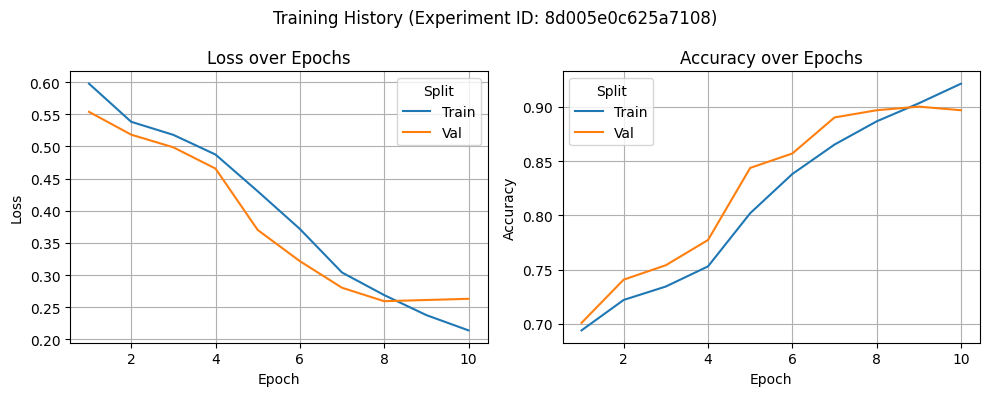

In [2]:
from typing import Any, Dict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_training_history(result_dict: Dict[str, Any]) -> None:
    """Plots training and validation loss/accuracy curves from the experiment results."""
    history = result_dict.get("history")
    if not history:
        print("No history data found in results.")
        return

    epochs = range(1, len(history.get("train_loss", [])) + 1)

    data = []
    for metric in ["loss", "accuracy"]:
        for split in ["train", "val"]:
            key = f"{split}_{metric}"
            values = history.get(key)
            if values:
                for epoch, value in zip(epochs, values):
                    data.append(
                        {
                            "Epoch": epoch,
                            "Value": value,
                            "Metric": metric.capitalize(),
                            "Split": split.capitalize(),
                        }
                    )

    if not data:
        print("History data is empty or missing required keys.")
        return

    history_df = pd.DataFrame(data)

    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"Training History (Experiment ID: {result_dict.get('id', 'N/A')})")

    loss_df = history_df[history_df["Metric"] == "Loss"]
    sns.lineplot(data=loss_df, x="Epoch", y="Value", hue="Split", ax=axes[0])
    axes[0].set_title("Loss over Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].grid(True)

    acc_df = history_df[history_df["Metric"] == "Accuracy"]
    sns.lineplot(data=acc_df, x="Epoch", y="Value", hue="Split", ax=axes[1])
    axes[1].set_title("Accuracy over Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


plot_training_history(results)

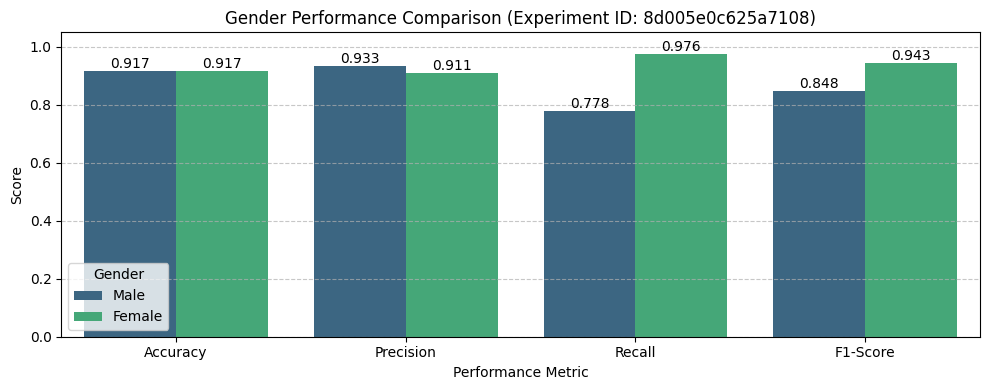

In [3]:
from typing import Any, Dict, Optional

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_gender_performance(result_dict: Dict[str, Any]) -> None:
    """Plots key performance metrics grouped by gender."""
    analysis = result_dict.get("analysis")
    if not analysis:
        print("No analysis data found in results.")
        return

    metrics_data = []
    gender_map = {"male_performance_metrics": "Male", "female_performance_metrics": "Female"}

    for key, gender_name in gender_map.items():
        metrics = analysis.get(key)
        if not metrics:
            print(f"Warning: {key} not found in analysis results.")
            continue

        tp = metrics.get("tp", 0)
        fp = metrics.get("fp", 0)
        tn = metrics.get("tn", 0)
        fn = metrics.get("fn", 0)
        total = tp + fp + tn + fn

        if total == 0:
            accuracy = 0.0
        else:
            accuracy = (tp + tn) / total

        if (tp + fp) == 0:
            precision = 0.0
        else:
            precision = tp / (tp + fp)  # PPV

        if (tp + fn) == 0:
            recall = 0.0
        else:
            recall = tp / (tp + fn)  # TPR

        if (precision + recall) == 0:
            f1 = 0.0
        else:
            f1 = 2 * (precision * recall) / (precision + recall)

        metrics_data.extend(
            [
                {"Metric": "Accuracy", "Score": accuracy, "Gender": gender_name},
                {"Metric": "Precision", "Score": precision, "Gender": gender_name},
                {"Metric": "Recall", "Score": recall, "Gender": gender_name},
                {"Metric": "F1-Score", "Score": f1, "Gender": gender_name},
            ]
        )

    if not metrics_data:
        print("No performance metrics could be extracted.")
        return

    metrics_df = pd.DataFrame(metrics_data)

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(data=metrics_df, x="Metric", y="Score", hue="Gender", palette="viridis")

    plt.title(f"Gender Performance Comparison (Experiment ID: {result_dict.get('id', 'N/A')})")
    plt.ylabel("Score")
    plt.xlabel("Performance Metric")
    plt.ylim(0, 1.05)  # Add a little space at the top
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f")

    plt.tight_layout()
    plt.show()


plot_gender_performance(results)

/tmp/ipykernel_54875/3280480250.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=metrics_df, x="Metric", y="Score", palette="viridis")


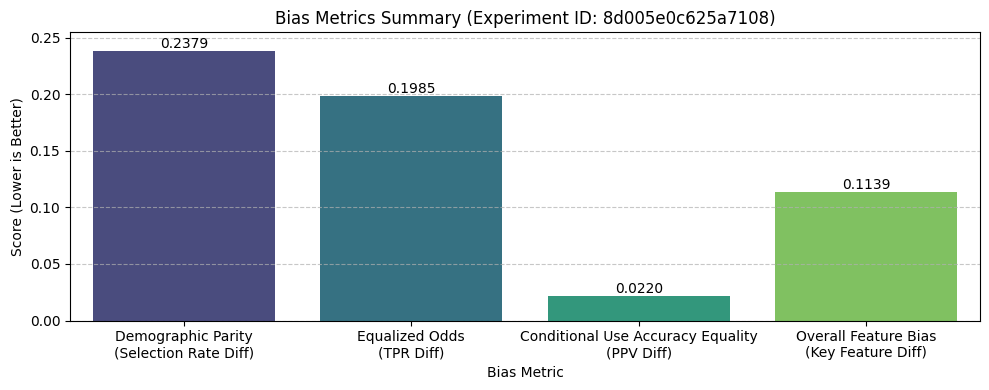

In [4]:
from typing import Any, Dict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_bias_metrics(result_dict: Dict[str, Any]) -> None:
    """Plots the calculated bias and fairness metrics."""
    analysis = result_dict.get("analysis")
    if not analysis:
        print("No analysis data found in results.")
        return

    bias_metrics = analysis.get("bias_metrics")
    if not bias_metrics:
        print("No bias_metrics data found in analysis results.")
        return

    metric_mapping = {
        "demographic_parity": "Demographic Parity\n(Selection Rate Diff)",
        "equalized_odds": "Equalized Odds\n(TPR Diff)",
        "conditional_use_accuracy_equality": "Conditional Use Accuracy Equality\n(PPV Diff)",
        "mean_feature_distribution_bias": "Overall Feature Bias\n(Key Feature Diff)",
    }

    plot_data = [{"Metric": metric_mapping.get(k, k), "Score": v} for k, v in bias_metrics.items() if k in metric_mapping]

    if not plot_data:
        print("No relevant bias metrics found for plotting.")
        return

    metrics_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(data=metrics_df, x="Metric", y="Score", palette="viridis")

    plt.title(f"Bias Metrics Summary (Experiment ID: {result_dict.get('id', 'N/A')})")
    plt.ylabel("Score (Lower is Better)")
    plt.xlabel("Bias Metric")
    plt.ylim(bottom=0, top=metrics_df["Score"].max() * 1.07)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.4f")

    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()


plot_bias_metrics(results)

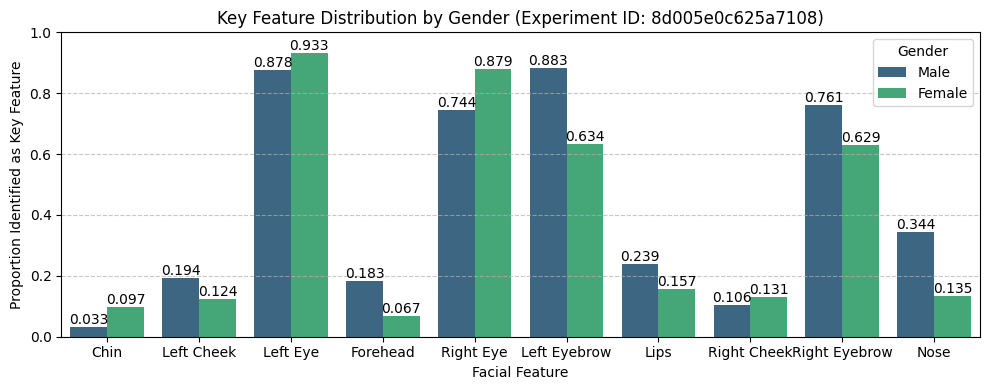

In [5]:
from typing import Any, Dict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_key_feature_distribution(result_dict: Dict[str, Any]) -> None:
    """Plots the distribution of key features identified, grouped by gender."""
    analysis = result_dict.get("analysis")
    if not analysis:
        print("No analysis data found in results.")
        return

    distributions = analysis.get("feature_distributions")
    if not distributions:
        print("No feature_distributions data found in analysis results.")
        return

    plot_data = []
    for item in distributions:
        feature_name = item.get("feature", "Unknown").replace("_", " ").title()
        male_prop = item.get("male_distribution")
        female_prop = item.get("female_distribution")

        if male_prop is not None:
            plot_data.append({"Feature": feature_name, "Proportion": male_prop, "Gender": "Male"})
        if female_prop is not None:
            plot_data.append({"Feature": feature_name, "Proportion": female_prop, "Gender": "Female"})

    if not plot_data:
        print("No valid feature distribution data could be extracted for plotting.")
        return

    dist_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 4))
    ax = sns.barplot(data=dist_df, x="Feature", y="Proportion", hue="Gender", palette="viridis")

    plt.title(f"Key Feature Distribution by Gender (Experiment ID: {result_dict.get('id', 'N/A')})")
    plt.ylabel("Proportion Identified as Key Feature")
    plt.xlabel("Facial Feature")
    plt.ylim(0, 1.0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f")
    plt.tight_layout()
    plt.show()


plot_key_feature_distribution(results)

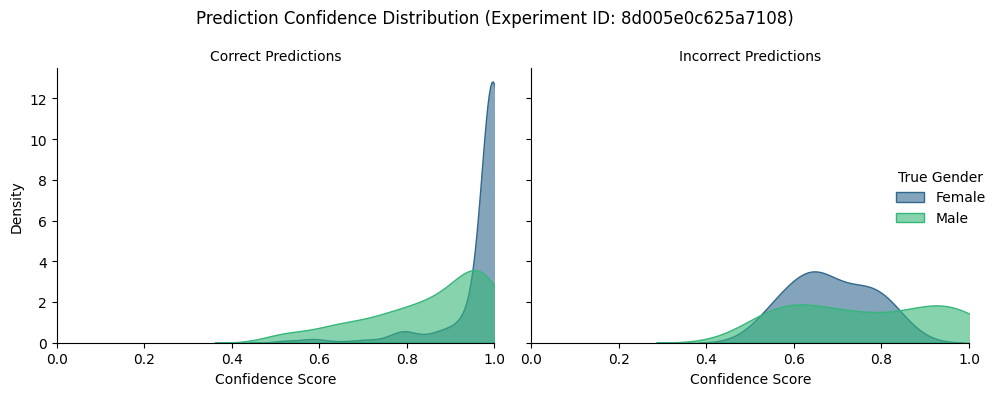

In [6]:
from typing import Any, Dict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_confidence_distribution(result_dict: Dict[str, Any]) -> None:
    """Plots the distribution of model prediction confidence scores, grouped by gender and correctness."""
    analysis = result_dict.get("analysis")
    if not analysis:
        print("No analysis data found in results.")
        return

    analyzed_images = analysis.get("analyzed_images")
    if not analyzed_images:
        print("No analyzed_images data found in analysis results.")
        return

    plot_data = []
    gender_map = {0: "Male", 1: "Female"}

    for img_data in analyzed_images:
        label = img_data.get("label")
        prediction = img_data.get("prediction")
        confidence_scores = img_data.get("confidence_scores")

        if label is None or prediction is None or not confidence_scores or len(confidence_scores) != 2:
            print(f"Skipping image {img_data.get('image_id', 'N/A')} due to missing/invalid data.")
            continue

        # Check if prediction index is valid before accessing confidence_scores
        if prediction not in [0, 1]:
            print(f"Skipping image {img_data.get('image_id', 'N/A')} due to invalid prediction value: {prediction}.")
            continue

        predicted_confidence = confidence_scores[prediction]
        is_correct = label == prediction
        correctness_label = "Correct" if is_correct else "Incorrect"
        true_gender_label = gender_map.get(label, "Unknown")

        plot_data.append(
            {
                "Confidence": predicted_confidence,
                "True Gender": true_gender_label,
                "Prediction Correctness": correctness_label,
            }
        )

    if not plot_data:
        print("No valid image explanation data could be extracted for plotting.")
        return

    confidence_df = pd.DataFrame(plot_data)

    g = sns.FacetGrid(
        confidence_df,
        col="Prediction Correctness",
        hue="True Gender",
        height=5,
        aspect=1,
        palette="viridis",
        sharey=True,
        sharex=True,
        col_order=["Correct", "Incorrect"],
    )

    g.map(sns.kdeplot, "Confidence", fill=True, alpha=0.6, common_norm=False)

    g.add_legend(title="True Gender")
    g.set_axis_labels("Confidence Score", "Density")
    g.set_titles(col_template="{col_name} Predictions")
    g.fig.suptitle(f"Prediction Confidence Distribution (Experiment ID: {result_dict.get('id', 'N/A')})")
    g.set(xlim=(0, 1))
    g.figure.set_size_inches(10, 4)

    plt.tight_layout()
    plt.show()


plot_confidence_distribution(results)

Skipping image 2005a6b56dd2f5ed due to missing detected_features.
Skipping image 1647a7f0cc74d737 due to missing detected_features.


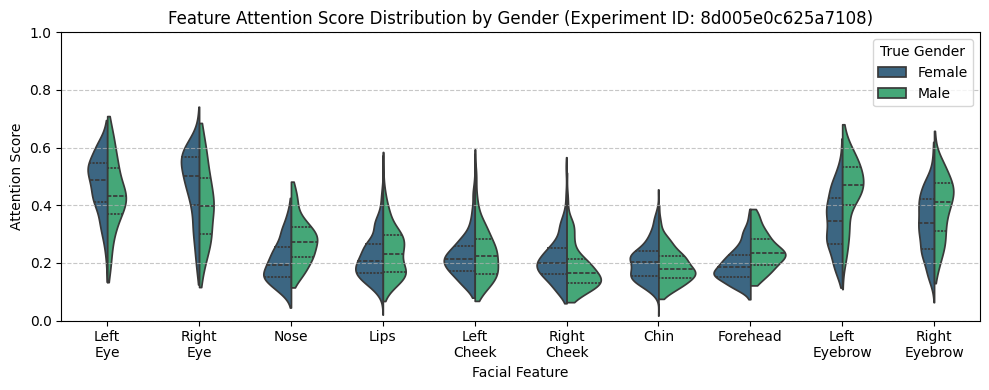

In [7]:
from typing import Any, Dict

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot_attention_distribution(result_dict: Dict[str, Any]) -> None:
    """Plots the distribution of attention scores per feature, grouped by gender."""
    analysis = result_dict.get("analysis")
    if not analysis:
        print("No analysis data found in results.")
        return

    analyzed_images = analysis.get("analyzed_images")
    if not analyzed_images:
        print("No analyzed_images data found in analysis results.")
        return

    plot_data = []
    gender_map = {0: "Male", 1: "Female"}

    for img_data in analyzed_images:
        label = img_data.get("label")
        true_gender_label = gender_map.get(label, "Unknown")

        if label is None:
            print(f"Skipping image {img_data.get('image_id', 'N/A')} due to missing label.")
            continue

        detected_features = img_data.get("detected_features", [])
        if not detected_features:
            print(f"Skipping image {img_data.get('image_id', 'N/A')} due to missing detected_features.")
            continue

        for feature_detail in detected_features:
            feature_name = feature_detail.get("feature", "Unknown").replace("_", "\n").title()
            attention_score = feature_detail.get("attention_score")

            if attention_score is not None:
                plot_data.append({"Feature": feature_name, "Attention Score": attention_score, "True Gender": true_gender_label})

    if not plot_data:
        print("No valid feature attention data could be extracted for plotting.")
        return

    attention_df = pd.DataFrame(plot_data)

    plt.figure(figsize=(10, 4))
    sns.violinplot(
        data=attention_df,
        x="Feature",
        y="Attention Score",
        hue="True Gender",
        split=True,
        inner="quart",
        palette="viridis",
        cut=0,
    )

    plt.title(f"Feature Attention Score Distribution by Gender (Experiment ID: {result_dict.get('id', 'N/A')})")
    plt.ylabel("Attention Score")
    plt.xlabel("Facial Feature")
    plt.ylim(0, 1.0)
    plt.grid(axis="y", linestyle="--", alpha=0.7)

    plt.tight_layout()
    plt.show()


plot_attention_distribution(results)

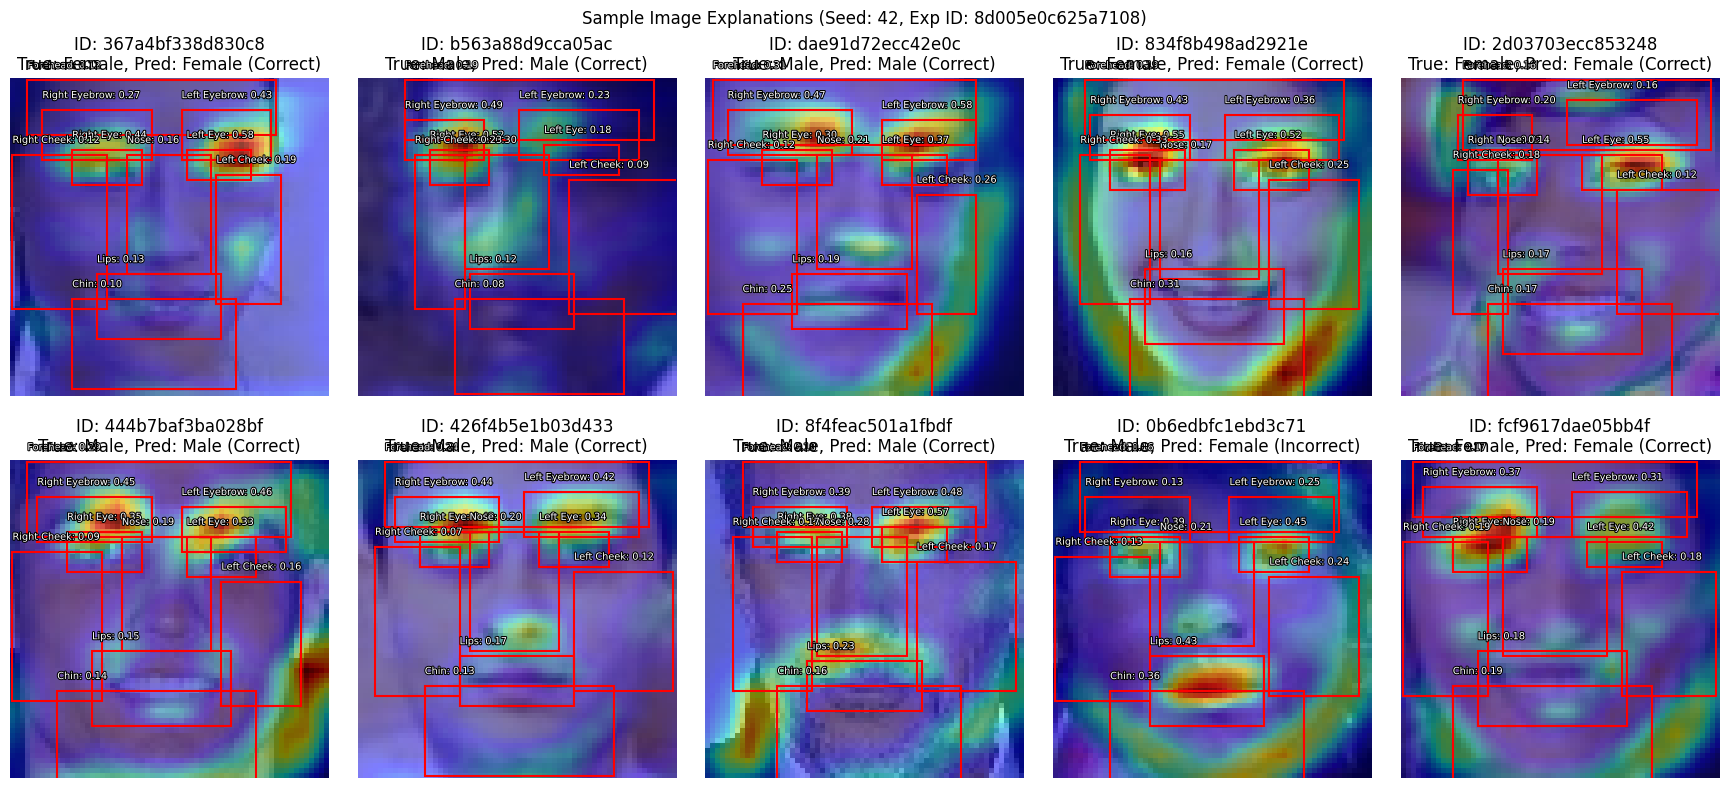

In [8]:
import os
import random
from typing import Any, Dict

import matplotlib.patches as patches
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


def plot_sample_explanations(result_dict: Dict[str, Any], rows: int, cols: int, seed: int) -> None:
    """Plots sample images overlaid with heatmaps and feature bounding boxes with attention scores."""
    analysis = result_dict.get("analysis")
    output_config = result_dict.get("config", {}).get("output")
    experiment_id = result_dict.get("id")

    if not analysis or not output_config or not experiment_id:
        print("Missing analysis data, output config, or experiment ID in results.")
        return

    analyzed_images = analysis.get("analyzed_images")
    base_path = output_config.get("base_path")

    if not analyzed_images:
        print("No analyzed_images data found in analysis results.")
        return
    if not base_path:
        print("Missing base_path in output config.")
        return

    num_samples = rows * cols
    if len(analyzed_images) < num_samples:
        print(f"Warning: Requested {num_samples} samples, but only {len(analyzed_images)} available.")
        num_samples = len(analyzed_images)
        cols = min(cols, num_samples)
        rows = (num_samples + cols - 1) // cols

    if num_samples == 0:
        print("No images to display.")
        return

    random.seed(seed)
    selected_samples = random.sample(analyzed_images, num_samples)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 4, rows * 4))
    axes = np.array(axes).flatten()

    gender_map = {0: "Male", 1: "Female"}

    for i, sample_data in enumerate(selected_samples):
        ax = axes[i]
        image_id = sample_data.get("image_id")
        heatmap_rel_path = sample_data.get("heatmap_path")
        label = sample_data.get("label")
        prediction = sample_data.get("prediction")
        detected_features = sample_data.get("detected_features", [])

        if not image_id or not heatmap_rel_path or label is None or prediction is None:
            ax.set_title(f"Skipping: Missing data (ID: {image_id})")
            ax.axis("off")
            continue

        heatmap_full_path = os.path.join(base_path, heatmap_rel_path)
        image_filename = f"test_{image_id}.png"
        image_path = os.path.join(base_path, experiment_id, "test_images", image_filename)

        try:
            img = Image.open(image_path).convert("RGB")
            heatmap = np.load(heatmap_full_path)

            heatmap_float32 = heatmap.astype(np.float32)
            heatmap_pil = Image.fromarray(heatmap_float32)
            heatmap_resized_pil = heatmap_pil.resize(img.size, Image.NEAREST)
            heatmap_resized = np.array(heatmap_resized_pil)

        except FileNotFoundError as e:
            ax.set_title(f"Error loading file: {e.filename}")
            ax.axis("off")
            continue
        except Exception as e:
            ax.set_title(f"Error: {e}")
            ax.axis("off")
            continue

        ax.imshow(img)
        ax.imshow(heatmap_resized, cmap="jet", alpha=0.5)

        for feature_detail in detected_features:
            bbox_data = feature_detail.get("bbox")
            feature_name = feature_detail.get("feature", "N/A").replace("_", " ").title()
            attention_score = feature_detail.get("attention_score", -1.0)

            if not bbox_data:
                continue

            min_x, min_y = bbox_data.get("min_x"), bbox_data.get("min_y")
            max_x, max_y = bbox_data.get("max_x"), bbox_data.get("max_y")

            if None in [min_x, min_y, max_x, max_y]:
                continue

            rect = patches.Rectangle((min_x, min_y), max_x - min_x, max_y - min_y, linewidth=1.5, edgecolor="r", facecolor="none")
            ax.add_patch(rect)

            label_text = f"{feature_name}: {attention_score:.2f}"
            txt = ax.text(min_x, min_y - 2, label_text, fontsize=7, color="white", va="bottom")
            txt.set_path_effects([PathEffects.withStroke(linewidth=1.5, foreground="black")])

        true_label_str = gender_map.get(label, "Unknown")
        pred_label_str = gender_map.get(prediction, "Unknown")
        correctness = "Correct" if label == prediction else "Incorrect"
        ax.set_title(f"ID: {image_id}\nTrue: {true_label_str}, Pred: {pred_label_str} ({correctness})")
        ax.axis("off")

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    fig.suptitle(f"Sample Image Explanations (Seed: {seed}, Exp ID: {experiment_id})")
    plt.tight_layout()
    fig.subplots_adjust(hspace=0.2, wspace=-0.4)
    plt.show()


plot_sample_explanations(results, rows=2, cols=5, seed=42)